In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression
import scienceplots
plt.style.use(["science", "no-latex"])

from sklearn.metrics import r2_score
from XrayTo3DShape import filter_wandb_run, get_run_from_model_name, MODEL_NAMES

/mnt/SSD0/mahesh-home/miniconda3/envs/xrayto3dbenchmark-cuda_11/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /mnt/SSD0/mahesh-home/miniconda3/envs/xrayto3dbenchmark-cuda_11/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


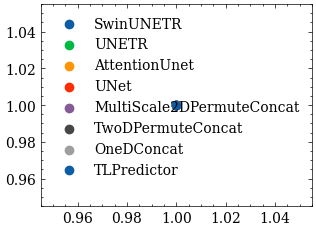

In [2]:
fig = plt.figure()
for model in MODEL_NAMES:
    plt.scatter(1,1,label=model)
    plt.legend()
plt.savefig('legend.pdf')

In [3]:
generalized_metrics_template = "../runs/2d-3d-benchmark/{run_id}/evaluation/metric-log.csv"
clinical_parameters_template = (
    "../runs/2d-3d-benchmark/{run_id}/evaluation/{clinical_log_name}"
)

In [4]:
hip_COLUMNS = ["ASIS_L", "ASIS_R", "PT_L", "PT_R", "IS_L", "IS_R", "PSIS_L", "PSIS_R"]
vertebra_COLUMNS = ["spl", "spa", "avbh", "pvbh", "svbl", "ivbl", "vcl"]
femur_COLUMNS = [
    "FHR",
    "FHC",
    "NSA",
    "FNA_x",
    "FNA_y",
    "FNA_z",
    "FDA_x",
    "FDA_y",
    "FDA_z",
]
anatomy_wise_details = {
    "hip": {
        "columns": hip_COLUMNS,
        "clinical_log_name": "hip_landmark_error.csv",
        "subject_id_post_fix": "_hip_msk",
    },
    "vertebra": {
        "columns": vertebra_COLUMNS,
        "clinical_log_name": "vertebra_morphometry_error.csv",
        "subject_id_post_fix": "-seg-vert-msk",
    },
    "femur": {
        "columns": femur_COLUMNS,
        "clinical_log_name": "femur_morphometry_error.csv",
        "subject_id_post_fix": "s0174_femur_righ",  # this is a prefix
    },
}

In [5]:
import scipy as sp
import scipy.stats as stats
def plot_ci_bootstrap(xs, ys, resid, nboot=500, ax=None):
    """Return an axes of confidence bands using a bootstrap approach.

    Notes
    -----
    The bootstrap approach iteratively resampling residuals.
    It plots `nboot` number of straight lines and outlines the shape of a band.
    The density of overlapping lines indicates improved confidence.

    Returns
    -------
    ax : axes
        - Cluster of lines
        - Upper and Lower bounds (high and low) (optional)  Note: sensitive to outliers

    References
    ----------
    .. [1] J. Stults. "Visualizing Confidence Intervals", Various Consequences.
       http://www.variousconsequences.com/2010/02/visualizing-confidence-intervals.html

    """ 
    if ax is None:
        ax = plt.gca()

    bootindex = sp.random.randint

    for _ in range(nboot):
        resamp_resid = resid[bootindex(0, len(resid) - 1, len(resid))]
        # Make coeffs of for polys
        pc = np.polyfit(xs, ys + resamp_resid, 1)                   
        # Plot bootstrap cluster
        ax.plot(xs, np.polyval(pc, xs), "b-", linewidth=2, alpha=3.0 / float(nboot))

    return ax

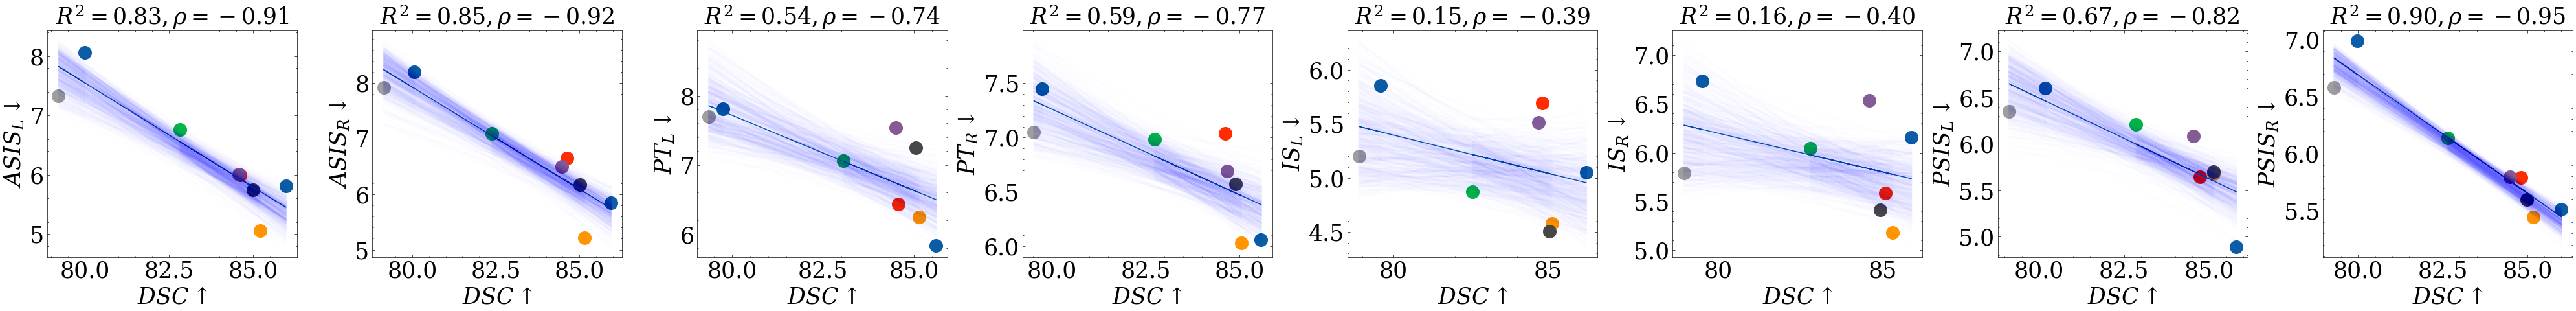

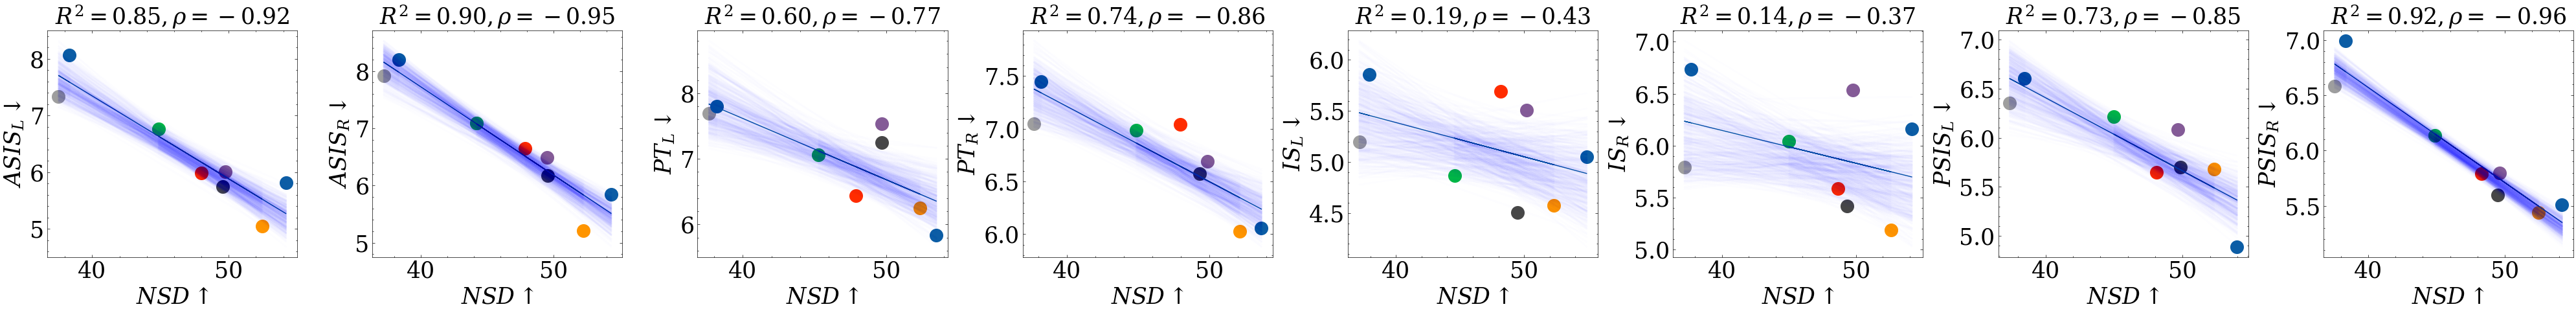

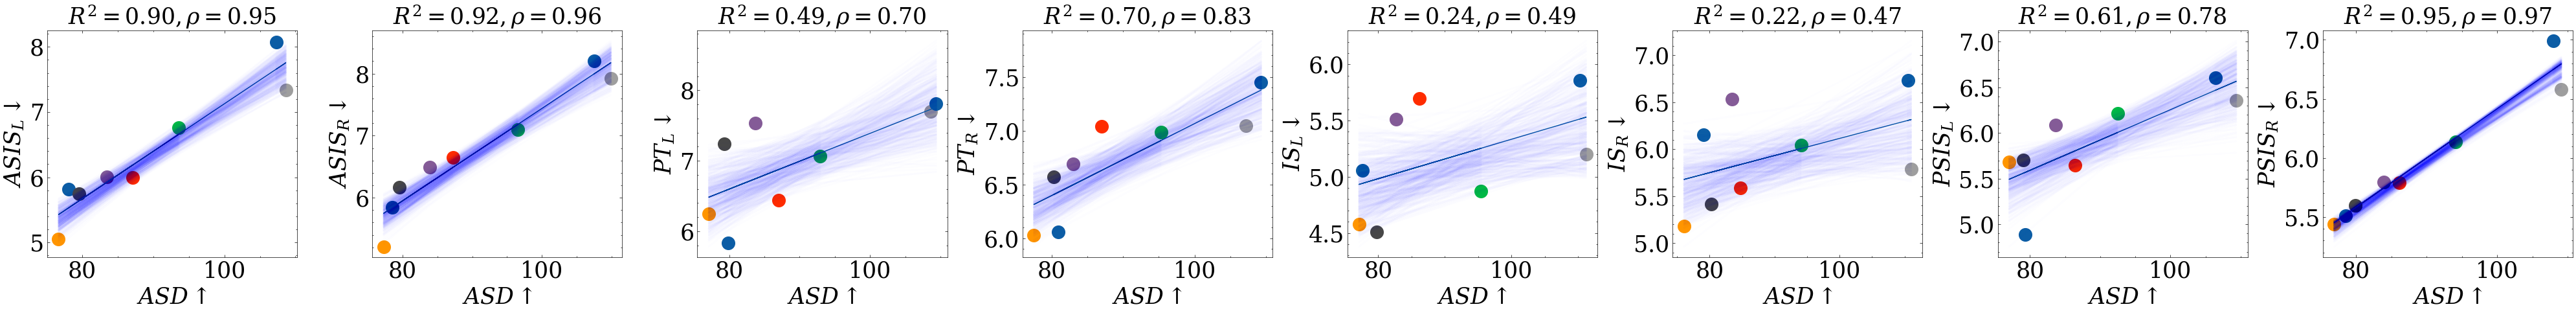

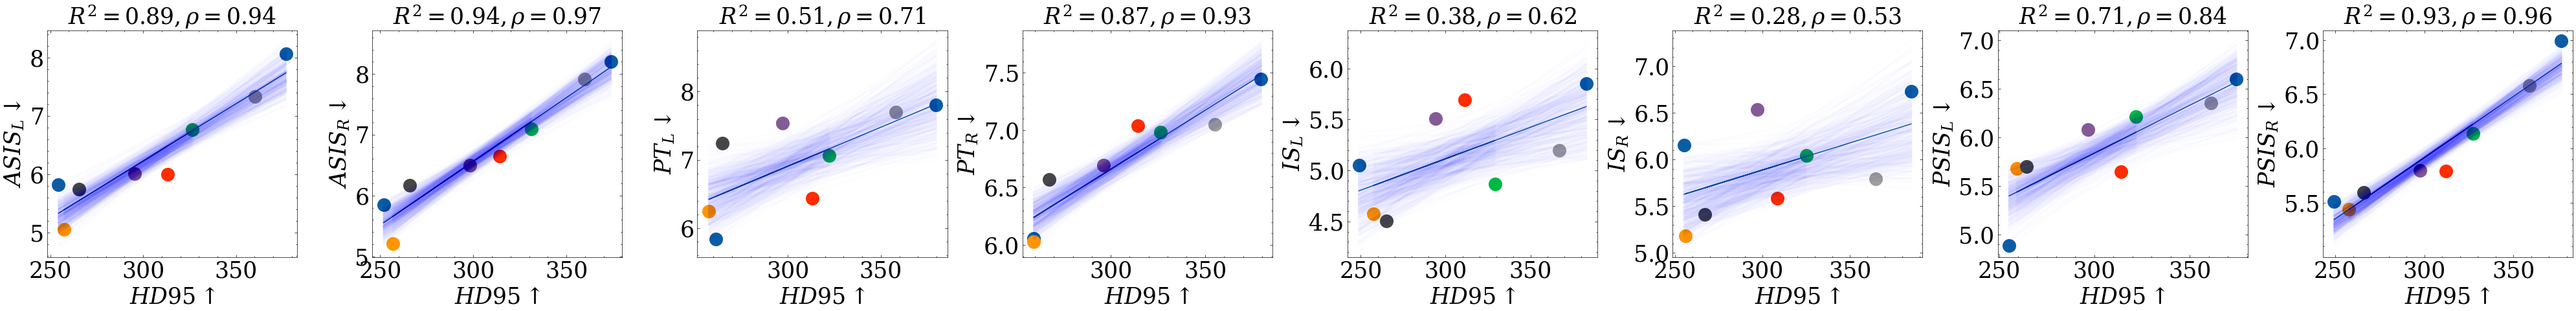

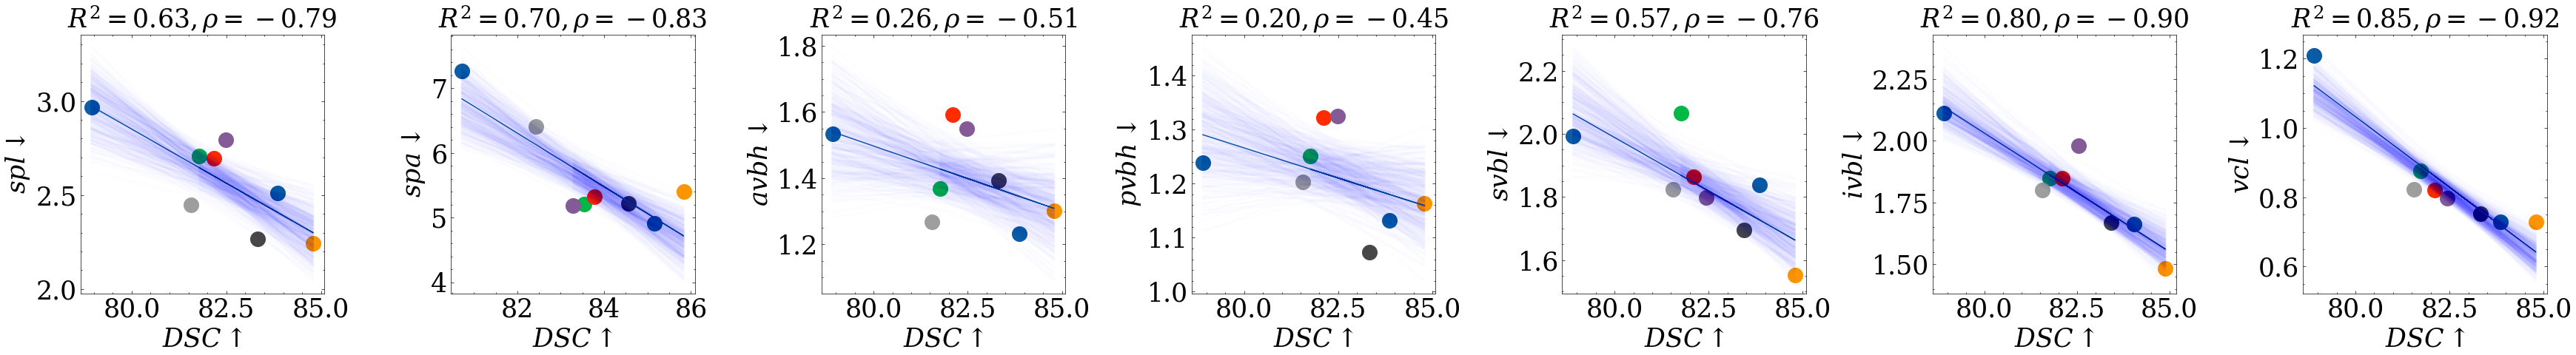

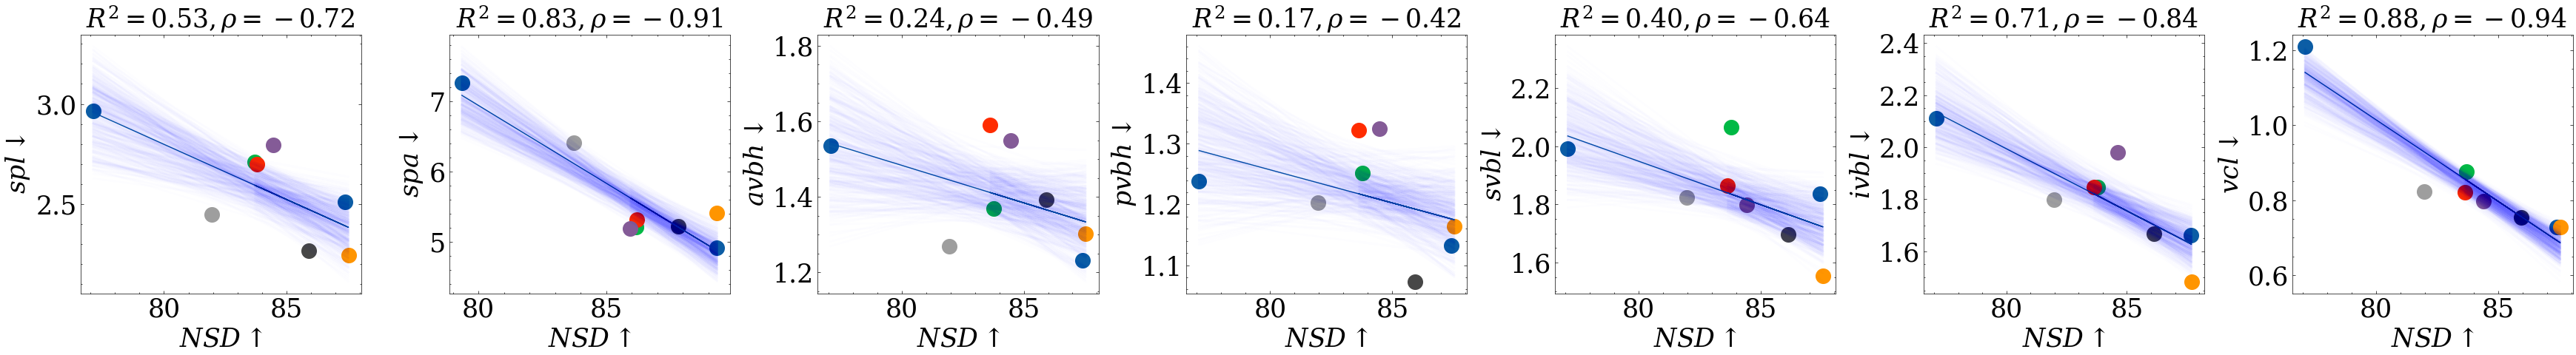

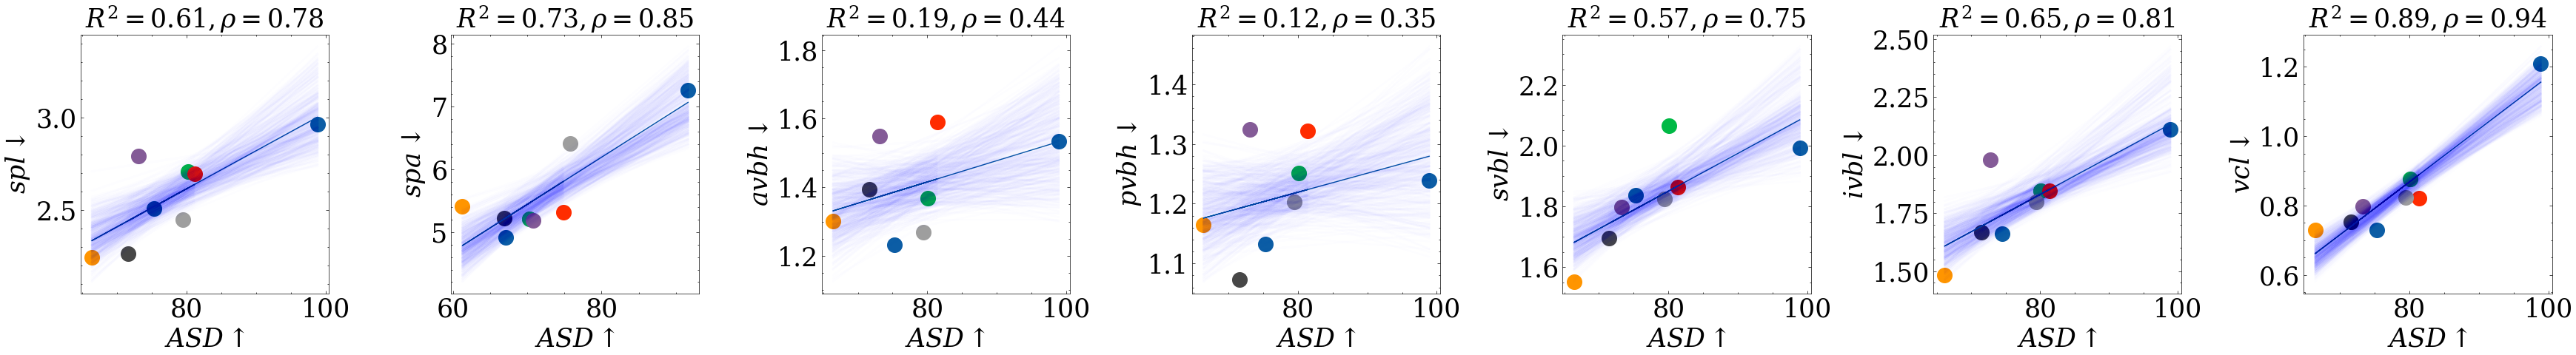

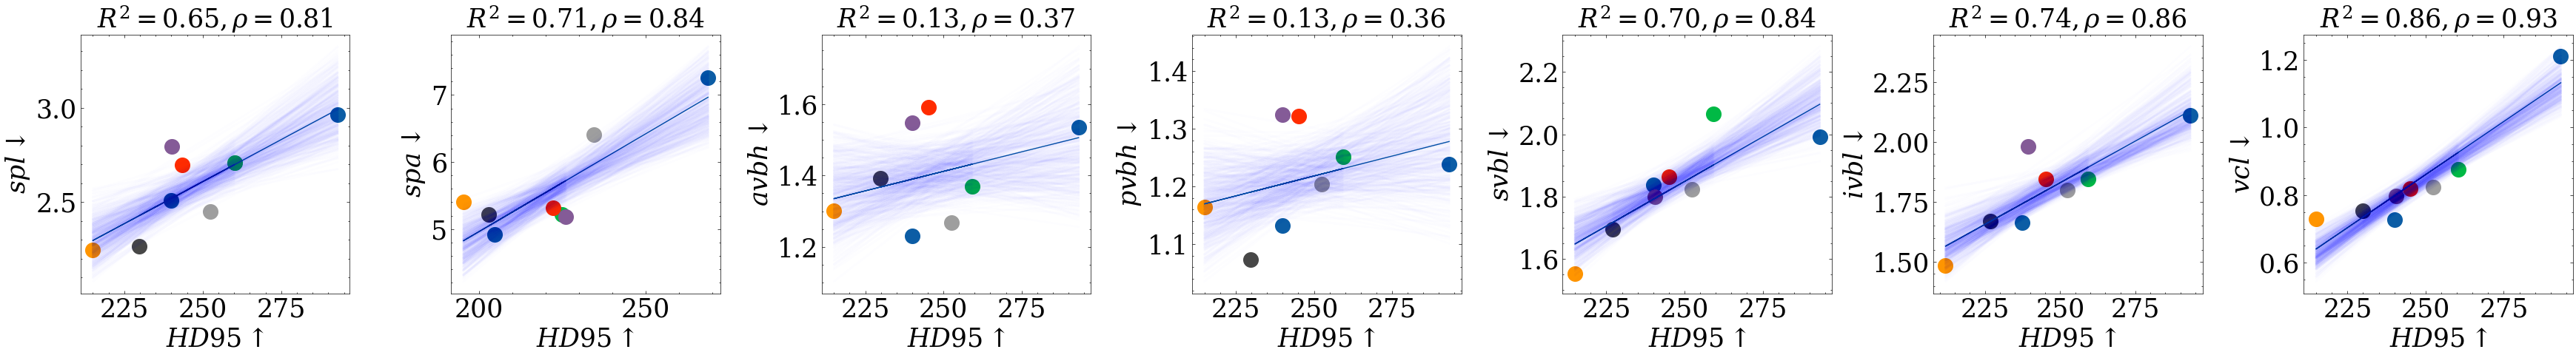

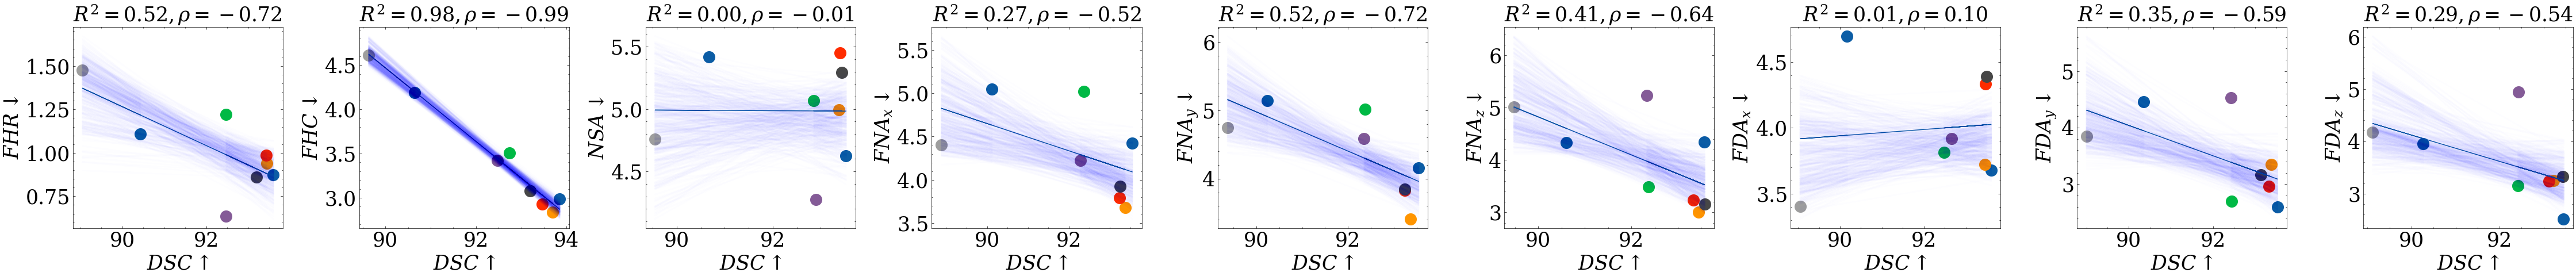

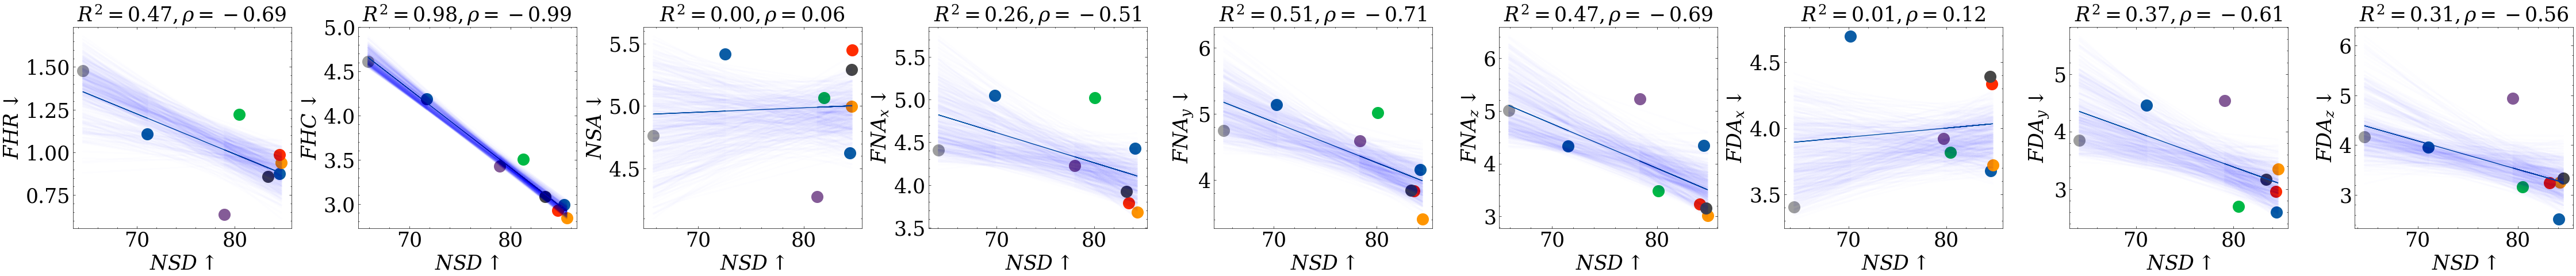

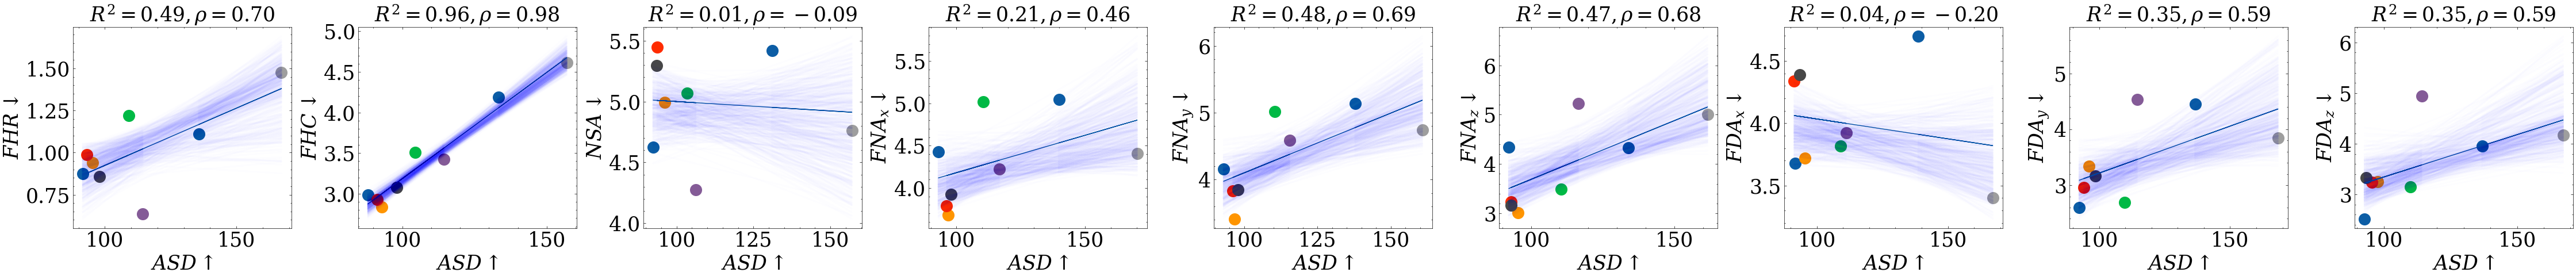

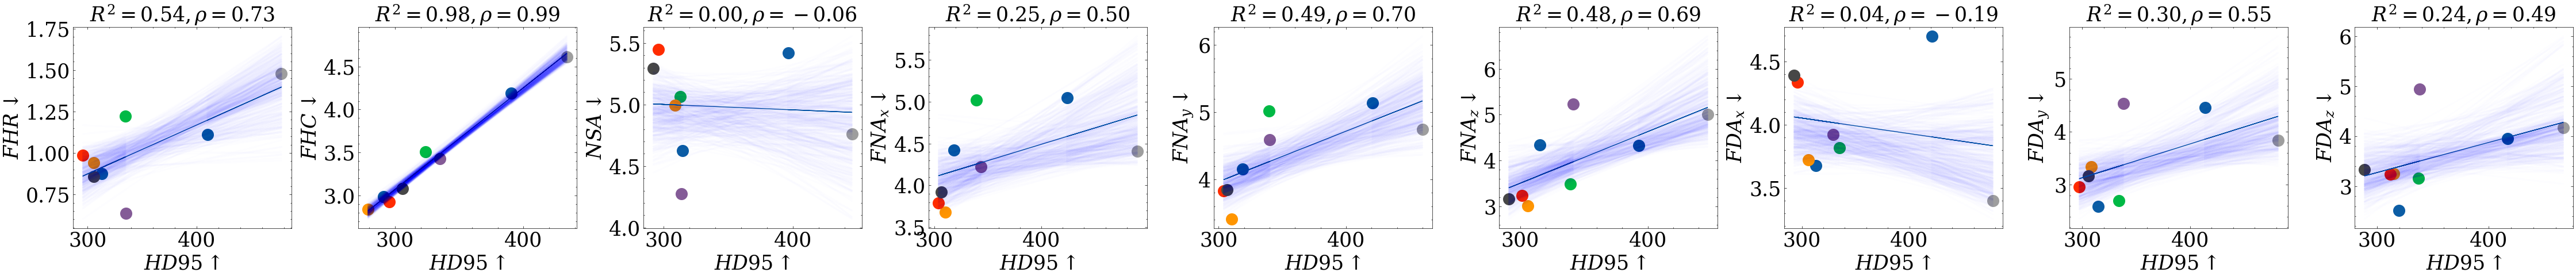

In [6]:
for ANATOMY in ['hip','vertebra','femur']:
    runs = filter_wandb_run(anatomy=ANATOMY, tags=['model-compare','dropout'])
    subplot_sz = 5
    rows = 1
    cols = len(anatomy_wise_details[ANATOMY]['columns'])
    for GENERALIZED_METRICS in ['DSC','NSD','ASD','HD95']:
        fig, ax = plt.subplots(rows, cols, figsize=(cols * subplot_sz, rows * subplot_sz))
        for clm_idx, clm in enumerate(anatomy_wise_details[ANATOMY]['columns']):
            dscs = []
            clinical_metrics = []
            for model in MODEL_NAMES:
                run = get_run_from_model_name(model,runs)

                clinical_csv = pd.read_csv(
                    clinical_parameters_template.format(
                        run_id=run.id,
                        clinical_log_name=anatomy_wise_details[ANATOMY]["clinical_log_name"],
                    )
                )
                generalized_metric_csv = pd.read_csv(
                    generalized_metrics_template.format(
                        run_id=run.id,
                    )
                )
                post_fix = anatomy_wise_details[ANATOMY]["subject_id_post_fix"]
                if ANATOMY == "femur":
                    post_fix_length = len(post_fix)  # this is actually a prefix so no negative sign
                else:
                    post_fix_length = -len(post_fix)
                generalized_metric_csv["id"] = generalized_metric_csv["subject-id"].str[
                    :post_fix_length
                ]
                merged_csv = pd.merge(clinical_csv,generalized_metric_csv,on='id',how='left')
                

                DSC = merged_csv.mean(numeric_only=True).DSC * 100
                NSD=  merged_csv.mean(numeric_only=True).NSD
                HD95= merged_csv.mean(numeric_only=True).HD95
                ASD=  merged_csv.mean(numeric_only=True).ASD

                metric = merged_csv.median(numeric_only=True)[clm]

                # print(merged_csv.head())

                threshold = merged_csv[clm].quantile(0.90)
                threshold = 15
                # merged_filtered_csv = merged_csv
                merged_filtered_csv = merged_csv[merged_csv[clm] < threshold].dropna()
                generalized_metric = merged_filtered_csv.mean(numeric_only=True)[GENERALIZED_METRICS]*100
                metric = merged_filtered_csv.mean(numeric_only=True)[clm]
                ax[clm_idx].scatter(generalized_metric,metric,s=200)
                # ax[clm_idx].scatter(merged_filtered_csv.DSC,merged_filtered_csv[clm])
                dscs.append(generalized_metric)
                clinical_metrics.append(metric)
            # fit regression line
            regressor = LinearRegression().fit(np.asarray(dscs).reshape(-1,1),clinical_metrics)
            y_pred = regressor.predict(np.asarray(dscs).reshape(-1,1))
            r2 = r2_score(clinical_metrics, y_pred)
            rho = np.corrcoef(dscs, clinical_metrics)[0,1]
            ax[clm_idx].set_title(r"$R^2={:.2f},\rho={:.2f}$".format(r2, rho), fontsize=25)
            ax[clm_idx].set_xlabel(r"${}\uparrow$".format(GENERALIZED_METRICS), fontsize=25)
            ax[clm_idx].set_ylabel(r"${}\downarrow$".format(clm), fontsize=25)
            ax[clm_idx].xaxis.set_tick_params(labelsize=25)
            ax[clm_idx].yaxis.set_tick_params(labelsize=25)
            ax[clm_idx].plot(dscs,y_pred)
            residual = np.asarray(clinical_metrics) - np.asarray(y_pred)
            plot_ci_bootstrap(np.asarray(dscs),np.asarray(clinical_metrics),resid=residual,ax=ax[clm_idx])
        plt.tight_layout()    
        plt.savefig(f'methodwise_dsc_vs_metrics_{ANATOMY}_{GENERALIZED_METRICS}.pdf',bbox_inches='tight')
        